<a href="https://colab.research.google.com/github/Man0j3/Image_processing_project/blob/main/image_processing_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import all required frameworks

In [ ]:
import os
import random

from collections import OrderedDict
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from tqdm import tqdm
from skimage.exposure import rescale_intensity
from skimage.io import imread, imsave
from skimage.transform import resize, rescale, rotate
from torch.utils.data import Dataset
from torchvision.transforms import Compose
import glob
import random
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid
# !pip uninstall opencv-python-headless
!pip install opencv-python-headless==4.1.2.30
import cv2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


# Importing Data

In [ ]:
# Path to all data
# DATA_PATH = "C://Users//Admin//Desktop//kaggle_3m//"
DATA_PATH ="/content/drive/MyDrive/kaggle_3m_1/"

# File path line length images for later sorting
BASE_LEN = 77 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 512
print(len("/content/drive/MyDrive/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_"))

77


In [ ]:
# Raw data
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()
print(df.head())

This is not a dir: /content/drive/MyDrive/kaggle_3m_1/README.md
This is not a dir: /content/drive/MyDrive/kaggle_3m_1/data.csv
                 dirname                                               path
0  TCGA_HT_7616_19940813  /content/drive/MyDrive/kaggle_3m_1/TCGA_HT_761...
1  TCGA_HT_7616_19940813  /content/drive/MyDrive/kaggle_3m_1/TCGA_HT_761...
2  TCGA_HT_7616_19940813  /content/drive/MyDrive/kaggle_3m_1/TCGA_HT_761...
3  TCGA_HT_7616_19940813  /content/drive/MyDrive/kaggle_3m_1/TCGA_HT_761...
4  TCGA_HT_7616_19940813  /content/drive/MyDrive/kaggle_3m_1/TCGA_HT_761...


In [ ]:
import re
p1 = re.compile('_([0-9]{1,2})[\.( ]')
p2 = re.compile('_([0-9]{1,2})_')
p3=re.compile('\(1\)')
# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
# toDropList=[]
for i, row in df_imgs.iterrows():
    if p3.search(row['path']):
        df_imgs=df_imgs.drop(df_imgs.index[i])
#         toDropList.append(i)
# for i in toDropList:
#     df_imgs=df_imgs.drop(df_imgs.index[i])

df_masks = df[df['path'].str.contains("mask")]
# df_masks = df[~df['path'].str.contains("(1)")]

# print(df_masks.head()["path"].values)
# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : 
              # int(x[BASE_LEN:-END_IMG_LEN]))
              # print(x))
              p1.search(x).group(1))
print(len(df_imgs.dirname.values),len(imgs))
masks = sorted(df_masks["path"].values, key=lambda x : 
               p2.search(x).group(1))
              #  int(x[BASE_LEN:-END_MASK_LEN]))
    # print(x[BASE_LEN:-END_MASK_LEN]))
    

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

213 213
Path to the Image: /content/drive/MyDrive/kaggle_3m_1/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_24.tif 
Path to the Mask: /content/drive/MyDrive/kaggle_3m_1/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_24_mask.tif


In [ ]:
# print(len(df_imgs.dirname.values))
# print(len(imgs),imgs[0])
# print(len(masks),masks[0])
# for i in range(len(imgs)):
p3=re.compile('\(1\)')
ntmp=len(masks)
for i in range(ntmp):
  if i<ntmp and p3.search(masks[i]):
    del masks[i]
    ntmp-=1
# n1tmp=len(imgs)
# for i in range(n1tmp):
#   if i<n1tmp and p3.search(imgs[i]):
#     del imgs[i]
#     n1tmp-=1
# print(len(df_imgs.dirname.values))
# print(len(imgs),imgs[0])
# print(len(masks),masks[0])

# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    # print(np.max(cv2.imread(mask_path)))
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

,patient,image_path,mask_path,diagnosis
0,TCGA_HT_7616_19940813,/content/drive/MyDrive/kaggle_3m_1/TCGA_HT_761...,/content/drive/MyDrive/kaggle_3m_1/TCGA_HT_761...,0
1,TCGA_HT_7616_19940813,/content/drive/MyDrive/kaggle_3m_1/TCGA_HT_A61...,/content/drive/MyDrive/kaggle_3m_1/TCGA_HT_A61...,0
2,TCGA_HT_7616_19940813,/content/drive/MyDrive/kaggle_3m_1/TCGA_FG_596...,/content/drive/MyDrive/kaggle_3m_1/TCGA_FG_596...,0
3,TCGA_HT_7616_19940813,/content/drive/MyDrive/kaggle_3m_1/TCGA_EZ_726...,/content/drive/MyDrive/kaggle_3m_1/TCGA_EZ_726...,0
4,TCGA_HT_7616_19940813,/content/drive/MyDrive/kaggle_3m_1/TCGA_CS_539...,/content/drive/MyDrive/kaggle_3m_1/TCGA_CS_539...,0
...,...,...,...,...
208,TCGA_DU_5853_19950823,/content/drive/MyDrive/kaggle_3m_1/TCGA_EZ_726...,/content/drive/MyDrive/kaggle_3m_1/TCGA_EZ_726...,0
209,TCGA_DU_5853_19950823,/content/drive/MyDrive/kaggle_3m_1/TCGA_CS_539...,/content/drive/MyDrive/kaggle_3m_1/TCGA_CS_539...,1
210,TCGA_DU_5853_19950823,/content/drive/MyDrive/kaggle_3m_1/TCGA_DU_585...,/content/drive/MyDrive/kaggle_3m_1/TCGA_DU_585...,0
211,TCGA_DU_5853_19950823,/content/drive/MyDrive/kaggle_3m_1/TCGA_CS_494...,/content/drive/MyDrive/kaggle_3m_1/TCGA_CS_494...,0


# Quick insight of data

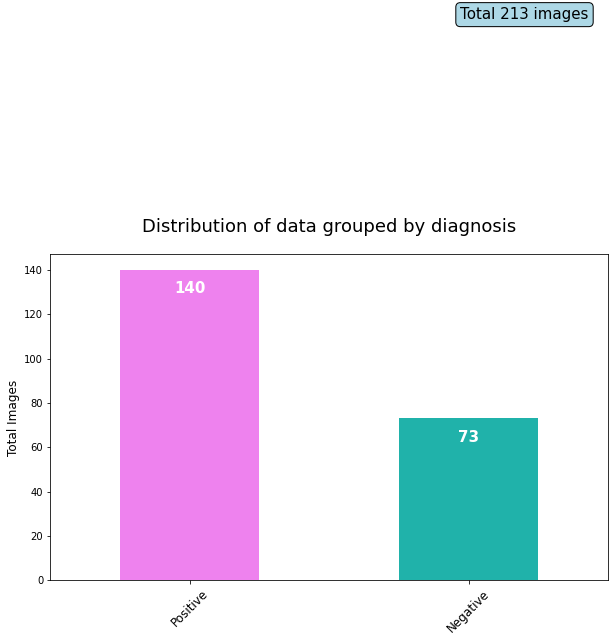

In [ ]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 255, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

Text(0.5, 1.005, 'Distribution of data grouped by patient and diagnosis')

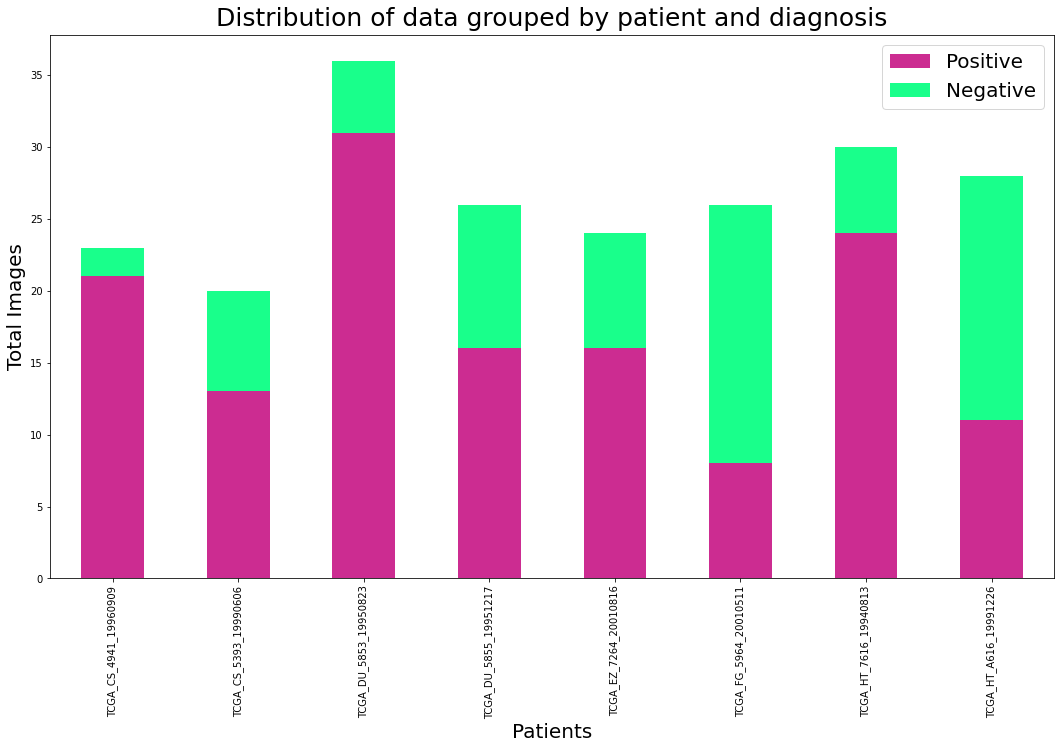

In [ ]:
# Data
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

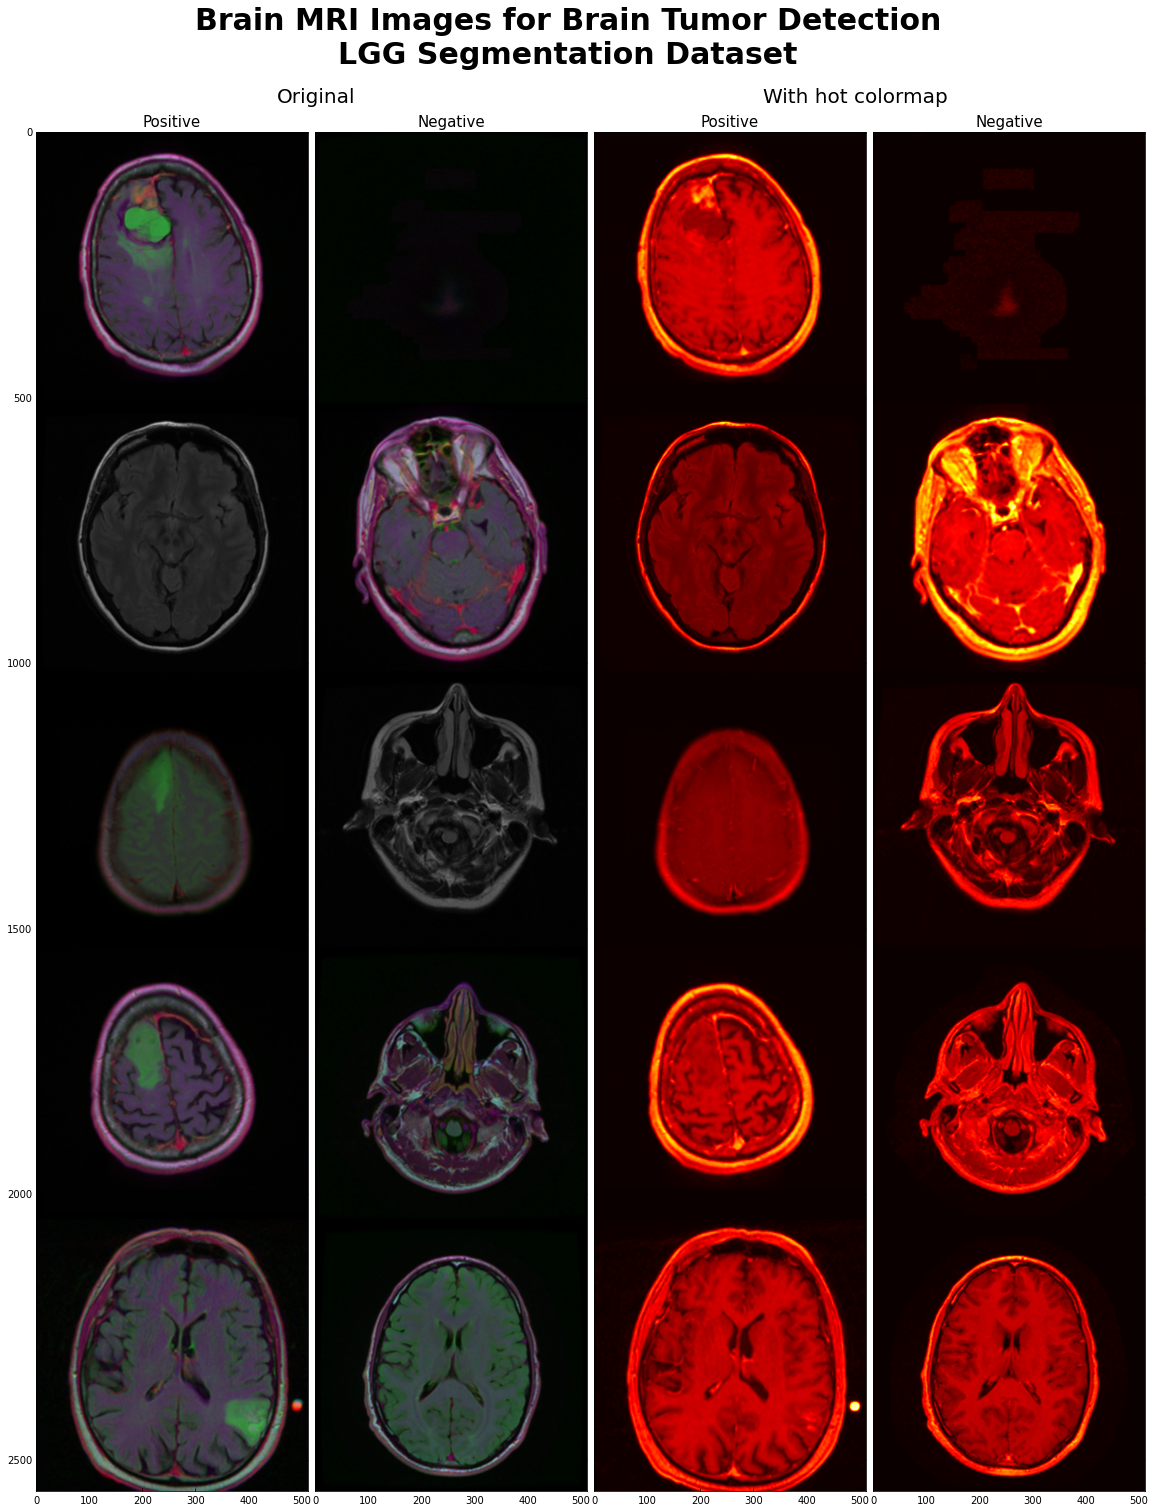

In [ ]:
# Data
sample_yes_df = df[df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = df[df["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)
# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

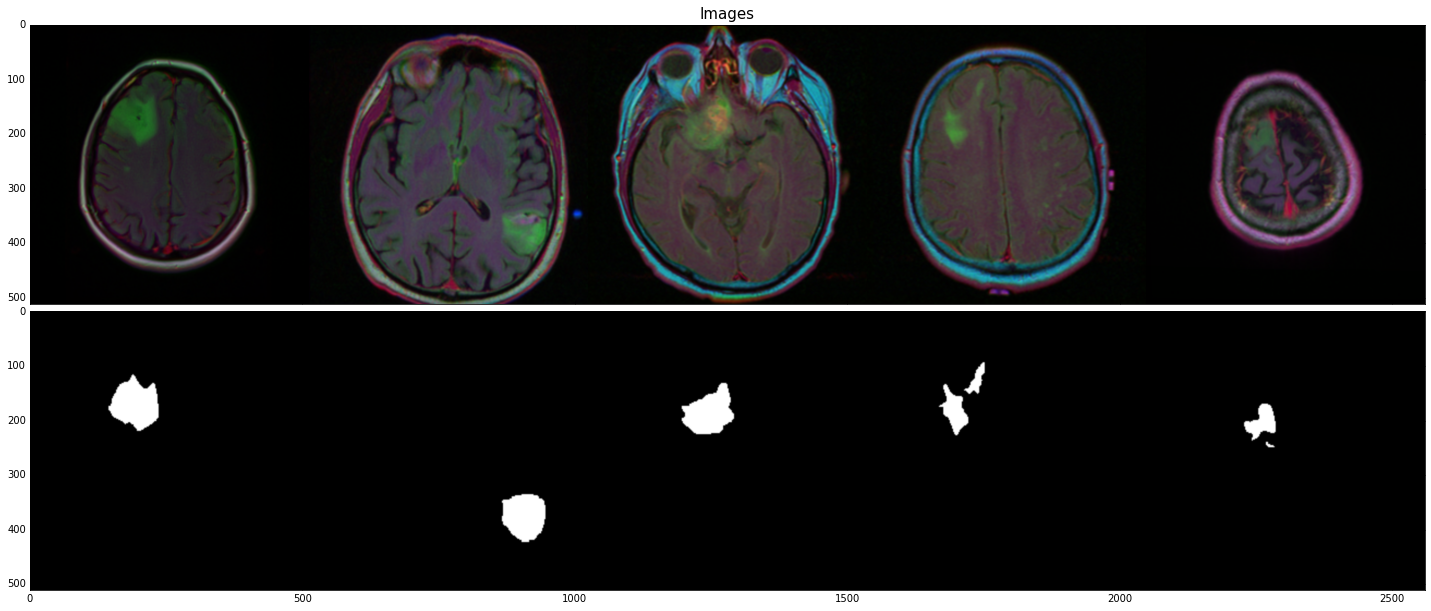

In [ ]:
# Data
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()


# Image Segmentation

In [ ]:
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# !pip install albumentations==0.4.6
import albumentations as A
! pip install albumentations==0.5.2
from albumentations.pytorch import ToTensor
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
#To perform transforms on  different dataframes
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):
        
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)

        augmented = self.transforms(image=image, 
                                    mask=mask)
 
        image = augmented['image']
        mask = augmented['mask']   
        
        return image, mask

In [ ]:
#Defining transformations
PATCH_SIZE = 128#256

strong_transforms = A.Compose([
    # A.augmentations.crops.transforms.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),
    
    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    ], p=0.8),
    
    
    A.Normalize(p=1.0),
    #https://albumentations.readthedocs.io/en/latest/api/pytorch.html?highlight=ToTensor#albumentations.pytorch.transforms.ToTensor
    ToTensor(),
])
transforms = A.Compose([
      
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    
    
    A.Normalize(p=1.0),
    ToTensor(),
])

In [ ]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (162, 4) 
Val: (22, 4) 
Test: (29, 4)


In [ ]:
#Specifying datasets and data loaders
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
# train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=4, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=40, num_workers=2, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=40, num_workers=2, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=4, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=40, num_workers=2, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=4, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([40, 3, 128, 128]) torch.Size([40, 1, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

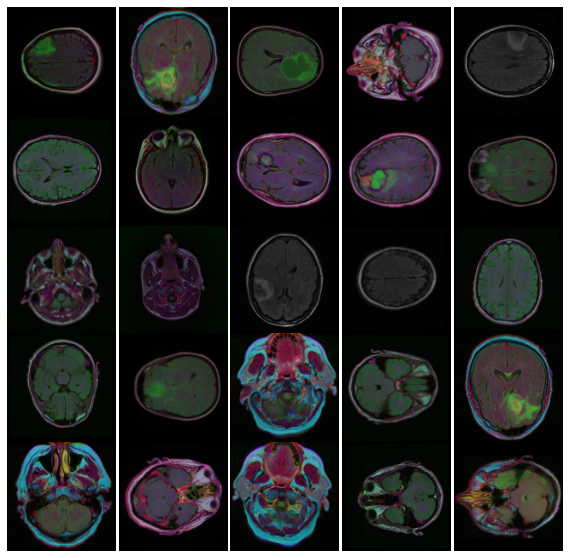

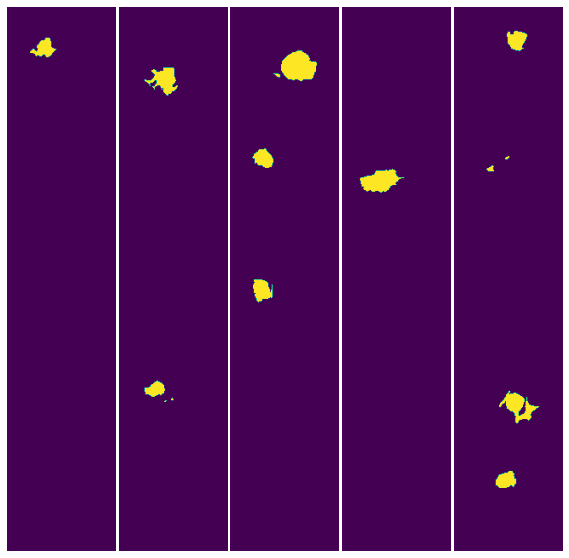

In [ ]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        #plot
        #print(img.max(), len(np.unique(img)))
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

    
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image=False)


In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

In [ ]:
class UNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
                
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(128 + 64, 64)
        
        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
        
    def forward(self, x):
        # Batch - 1d tensor.  N_channels - 1d tensor, IMG_SIZE - 2d tensor.
        # Example: x.shape >>> (10, 3, 256, 256).
        
        conv1 = self.conv_down1(x)  # <- BATCH, 3, IMG_SIZE  -> BATCH, 64, IMG_SIZE..
        x = self.maxpool(conv1)     # <- BATCH, 64, IMG_SIZE -> BATCH, 64, IMG_SIZE 2x down.
        conv2 = self.conv_down2(x)  # <- BATCH, 64, IMG_SIZE -> BATCH,128, IMG_SIZE.
        x = self.maxpool(conv2)     # <- BATCH, 128, IMG_SIZE -> BATCH, 128, IMG_SIZE 2x down.
        conv3 = self.conv_down3(x)  # <- BATCH, 128, IMG_SIZE -> BATCH, 256, IMG_SIZE.
        x = self.maxpool(conv3)     # <- BATCH, 256, IMG_SIZE -> BATCH, 256, IMG_SIZE 2x down.
        x = self.conv_down4(x)      # <- BATCH, 256, IMG_SIZE -> BATCH, 512, IMG_SIZE.
        x = self.upsample(x)        # <- BATCH, 512, IMG_SIZE -> BATCH, 512, IMG_SIZE 2x up.
        
        #(Below the same)                                 N this       ==        N this.  Because the first N is upsampled.
        x = torch.cat([x, conv3], dim=1) # <- BATCH, 512, IMG_SIZE & BATCH, 256, IMG_SIZE--> BATCH, 768, IMG_SIZE.
        
        x = self.conv_up3(x) #  <- BATCH, 768, IMG_SIZE --> BATCH, 256, IMG_SIZE. 
        x = self.upsample(x)  #  <- BATCH, 256, IMG_SIZE -> BATCH,  256, IMG_SIZE 2x up.   
        x = torch.cat([x, conv2], dim=1) # <- BATCH, 256,IMG_SIZE & BATCH, 128, IMG_SIZE --> BATCH, 384, IMG_SIZE.  

        x = self.conv_up2(x) # <- BATCH, 384, IMG_SIZE --> BATCH, 128 IMG_SIZE. 
        x = self.upsample(x)   # <- BATCH, 128, IMG_SIZE --> BATCH, 128, IMG_SIZE 2x up.     
        x = torch.cat([x, conv1], dim=1) # <- BATCH, 128, IMG_SIZE & BATCH, 64, IMG_SIZE --> BATCH, 192, IMG_SIZE.  
        
        x = self.conv_up1(x) # <- BATCH, 128, IMG_SIZE --> BATCH, 64, IMG_SIZE.
        
        out = self.last_conv(x) # <- BATCH, 64, IMG_SIZE --> BATCH, n_classes, IMG_SIZE.
        out = torch.sigmoid(out)
        
        return out

In [ ]:
unet = UNet(n_classes=1).to(device)
output = unet(torch.randn(1,3,256,256).to(device))
print("",output.shape)
print(output)
# unet.summary()
print(unet)

 torch.Size([1, 1, 256, 256])
tensor([[[[0.5255, 0.5260, 0.5264,  ..., 0.5238, 0.5255, 0.5250],
          [0.5242, 0.5262, 0.5259,  ..., 0.5248, 0.5245, 0.5223],
          [0.5260, 0.5253, 0.5252,  ..., 0.5244, 0.5253, 0.5247],
          ...,
          [0.5262, 0.5260, 0.5279,  ..., 0.5271, 0.5259, 0.5239],
          [0.5257, 0.5254, 0.5268,  ..., 0.5268, 0.5257, 0.5251],
          [0.5256, 0.5269, 0.5257,  ..., 0.5279, 0.5260, 0.5260]]]],
       grad_fn=<SigmoidBackward0>)
UNet(
  (conv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_down3): Sequential(
    (0): 

In [ ]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

In [ ]:
class ResNeXtUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        #print(d1.shape)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)
        
        return out

In [ ]:
rx50 = ResNeXtUNet(n_classes=1).to(device)
output = rx50(torch.randn(1,3,256,256).to(device))
print(output.shape)
print(rx50)

torch.Size([1, 1, 256, 256])
ResNeXtUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inpla

In [ ]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

# Metric check
dice_coef_metric(np.array([0., 0.9]), 
                 np.array([0., 1]))

0.9473684210526316

In [ ]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# loss check
bce_dice_loss(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

In [ ]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):  
    
    print(model_name)
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        print("Epoch: ",epoch)
        model.train() # Enter train mode
        
        losses = []
        train_iou = []
                
        if lr_scheduler:
            
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
        
        
        for i_step, (data, target) in enumerate(train_loader):
            print("i_step:",i_step)
            data = data.to(device)
            target = target.to(device)
                      
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if lr_scheduler:
                lr_scheduler.step()
 
        #torch.save(model.state_dict(), f'{model_name}_{str(epoch)}_epoch.pt')
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history
def compute_iou(model, loader, threshold=0.3):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    #model.eval()
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            #prediction = model(x_gpu)
            
            outputs = model(data)
           # print("val_output:", outputs.shape)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

        print("Threshold:  " + str(threshold) + "  Validation DICE score:", valloss / i_step)
    print("valloss",valloss,"i_step",i_step)
    return valloss / i_step

In [ ]:
# Optimizers
unet_optimizer = torch.optim.Adamax(unet.parameters(), lr=1e-3)
# fpn_optimizer = torch.optim.Adamax(fpn.parameters(), lr=1e-3)
rx50_optimizer = torch.optim.Adam(rx50.parameters(), lr=5e-4)

# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [32]:
num_ep = 8                                                                                             
# Train UNet
# unet_lh, unet_th, unet_vh = train_model("UNet", unet, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, False, num_ep) 

# Train FPN
# fpn_lh, fpn_th, fpn_vh = train_model("FPN", fpn, train_dataloader, val_dataloader, bce_dice_loss, fpn_optimizer, False, 20)#

# Train ResNeXt50Unet
rx50_lh, rx50_th, rx50_vh = train_model("ResNeXt50Unet", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, False, num_ep)

ResNeXt50Unet
Epoch:  0
i_step: 0
i_step: 1
i_step: 2
i_step: 3
i_step: 4
Threshold:  0.3  Validation DICE score: nan
valloss 0.0 i_step 0
Epoch [0]
Mean loss on train: 1.531124973297119 
Mean DICE on train: 0.0 
Mean DICE on validation: nan
Epoch:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in double_scalars


i_step: 0
i_step: 1
i_step: 2
i_step: 3
i_step: 4
Threshold:  0.3  Validation DICE score: nan
valloss 0.0 i_step 0
Epoch [1]
Mean loss on train: 1.0338854789733887 
Mean DICE on train: 0.0 
Mean DICE on validation: nan
Epoch:  2
i_step: 0
i_step: 1
i_step: 2
i_step: 3
i_step: 4
Threshold:  0.3  Validation DICE score: nan
valloss 0.0 i_step 0
Epoch [2]
Mean loss on train: 0.9487782478332519 
Mean DICE on train: 0.2 
Mean DICE on validation: nan
Epoch:  3
i_step: 0
i_step: 1
i_step: 2
i_step: 3
i_step: 4
Threshold:  0.3  Validation DICE score: nan
valloss 0.0 i_step 0
Epoch [3]
Mean loss on train: 0.8799474239349365 
Mean DICE on train: 0.2 
Mean DICE on validation: nan
Epoch:  4
i_step: 0
i_step: 1
i_step: 2
i_step: 3
i_step: 4
Threshold:  0.3  Validation DICE score: inf
valloss 0.6061038220193953 i_step 0
Epoch [4]
Mean loss on train: 0.8382056713104248 
Mean DICE on train: 0.0 
Mean DICE on validation: inf
Epoch:  5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in double_scalars


i_step: 0
i_step: 1
i_step: 2
i_step: 3
i_step: 4
Threshold:  0.3  Validation DICE score: inf
valloss 0.3327670177823083 i_step 0
Epoch [5]
Mean loss on train: 0.7613646149635315 
Mean DICE on train: 0.0 
Mean DICE on validation: inf
Epoch:  6
i_step: 0
i_step: 1
i_step: 2
i_step: 3
i_step: 4
Threshold:  0.3  Validation DICE score: inf
valloss 0.5887353878852285 i_step 0
Epoch [6]
Mean loss on train: 0.6959297299385071 
Mean DICE on train: 0.0 
Mean DICE on validation: inf
Epoch:  7
i_step: 0
i_step: 1
i_step: 2
i_step: 3
i_step: 4
Threshold:  0.3  Validation DICE score: inf
valloss 0.43064250411861615 i_step 0
Epoch [7]
Mean loss on train: 0.6173765540122986 
Mean DICE on train: 0.0 
Mean DICE on validation: inf


In [33]:
print(rx50_lh,rx50_th,rx50_vh)
# print(unet_lh, unet_th, unet_vh)
# rx50.eval()

[1.531124973297119, 1.0338854789733887, 0.9487782478332519, 0.8799474239349365, 0.8382056713104248, 0.7613646149635315, 0.6959297299385071, 0.6173765540122986] [0.0, 0.0, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0] [nan, nan, nan, nan, inf, inf, inf, inf]


In [34]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    fn = str(int(time.time())) + ".png"
    plt.show()
    #plt.savefig(fn, bbox_inches='tight', pad_inches=0.2)
    #plt.close()

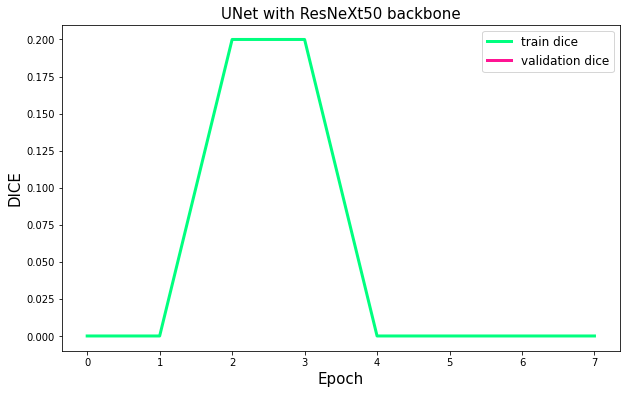

In [35]:
# plot_model_history("UNet", unet_th, unet_vh, num_ep)
#plot_model_history("FPN", fpn_th, fpn_vh, 20)
plot_model_history("UNet with ResNeXt50 backbone", rx50_th, rx50_vh, num_ep)

In [ ]:
# test_iou = compute_iou(rx50, test_dataloader)
# print("test_iou",test_iou)
# # test_iou = compute_iou(unet, test_dataloader)
# # print(f"""UNet\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")
# print(f"""ResNext50\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")
# # ResNext50

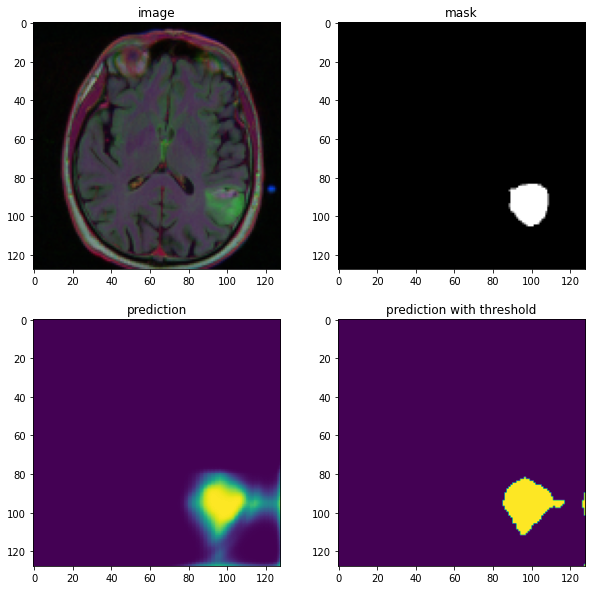

In [36]:
# image
test_sample = test_df[test_df["diagnosis"] == 1].sample(4).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

#mask
mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = rx50(pred.to(device))
# pred = unet(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

In [37]:
# print(test_df[test_df["diagnosis"] == 1].sample(5))
test_samples = test_df[test_df["diagnosis"] == 1].sample(10).values


def batch_preds_overlap(model, samples):
    """
    Computes prediction on the dataset
    
    Returns: list with images overlapping with predictions
    
    """
    prediction_overlap = []
    #model.eval():
    for test_sample in samples:

         # sample
        image = cv2.resize(cv2.imread(test_sample[1]),(128, 128))
        image =  image / 255.

        # gt
        ground_truth = cv2.resize(cv2.imread(test_sample[2], 0), (128, 128)).astype("uint8")

        # pred
        prediction = torch.tensor(image).unsqueeze(0).permute(0,3,1,2)
        prediction = model(prediction.to(device).float())
        prediction = prediction.detach().cpu().numpy()[0,0,:,:]

        prediction[np.nonzero(prediction < 0.3)] = 0.0
        prediction[np.nonzero(prediction >= 0.3)] = 255.#1.0
        prediction = prediction.astype("uint8")

        # overlap 
        original_img = cv2.resize(cv2.imread(test_sample[1]),(128, 128))

        _, thresh_gt = cv2.threshold(ground_truth, 127, 255, 0)
        _, thresh_p = cv2.threshold(prediction, 127, 255, 0)
        contours_gt, _ = cv2.findContours(thresh_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_p, _ = cv2.findContours(thresh_p, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        overlap_img = cv2.drawContours(original_img, contours_gt, 0, (0, 255, 0), 1)
        overlap_img = cv2.drawContours(overlap_img, contours_p, 0, (255,36,0), 1)#255,0,0
        prediction_overlap.append(overlap_img)

    return prediction_overlap
prediction_overlap_r = batch_preds_overlap(rx50, test_samples)
# prediction_overlap_r = batch_preds_overlap(unet, test_samples)
print(len(prediction_overlap_r))

10


In [38]:
pred_overlap_5x1_r = []
pred_overlap_5x3_r = []

for i in range(2, 5, 2):
    # print(i)
    #pred_overlap_5x1_u.append(np.hstack(np.array(prediction_overlap_u[i-5:i])))
    #pred_overlap_5x1_f.append(np.hstack(np.array(prediction_overlap_f[i-5:i])))
    pred_overlap_5x1_r.append(np.hstack(np.array(prediction_overlap_r[i-2:i])))

for i in range(3, 5, 3):
   #pred_overlap_5x3_u.append(np.vstack(pred_overlap_5x1_u[i-3:i]))
   #pred_overlap_5x3_f.append(np.vstack(pred_overlap_5x1_f[i-3:i]))
    pred_overlap_5x3_r.append(np.vstack(pred_overlap_5x1_r[i-3:i]))

In [39]:
# PLOT

def plot_plate_overlap(batch_preds, title, num):
    plt.figure(figsize=(15, 15))
    plt.imshow(batch_preds)
    plt.axis("off")

    plt.figtext(0.76,0.75,"Green - Ground Truth", va="center", ha="center", size=20,color="lime");
    plt.figtext(0.26,0.75,"Red - Prediction", va="center", ha="center", size=20, color="#ff0d00");
    plt.suptitle(title, y=.80, fontsize=20, weight="bold", color="#00FFDE");

    fn = "_".join((title+str(num)).lower().split()) + ".png"
    plt.savefig(fn, bbox_inches='tight', pad_inches=0.2, transparent=False, facecolor='black')
    plt.close()

    

title1 = "Predictions of UNet"
title2 = "Predictions of FPN"
title3 = "Predictions of UNet with ResNeXt50 backbone"

for num, batch in enumerate(pred_overlap_5x3_r):
    # plot_plate_overlap(batch,title1, num)
    plot_plate_overlap(batch,title3, num)

In [40]:
from PIL import Image

def make_gif(title):
    base_name = "_".join(title.lower().split())
    print("base_name:",base_name)

    base_len = len(base_name) 
    end_len = len(".png")
    fp_in = f"{base_name}*.png"
    fp_out = f"{base_name}.gif"
    print("fp_in:",fp_in)
    print("fp_out:",fp_out)
    img, *imgs = [Image.open(f) 
                  for f in sorted(glob.glob(fp_in), 
                                  key=lambda x : int(x[base_len:-end_len]))]

    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1000, loop=0)
    
    return fp_out

# fn1 = make_gif(title1)
#fn2 = make_gif(title2)
fn3 = make_gif(title3)

base_name: predictions_of_unet_with_resnext50_backbone
fp_in: predictions_of_unet_with_resnext50_backbone*.png
fp_out: predictions_of_unet_with_resnext50_backbone.gif


In [41]:
from IPython.display import Image as Image_display


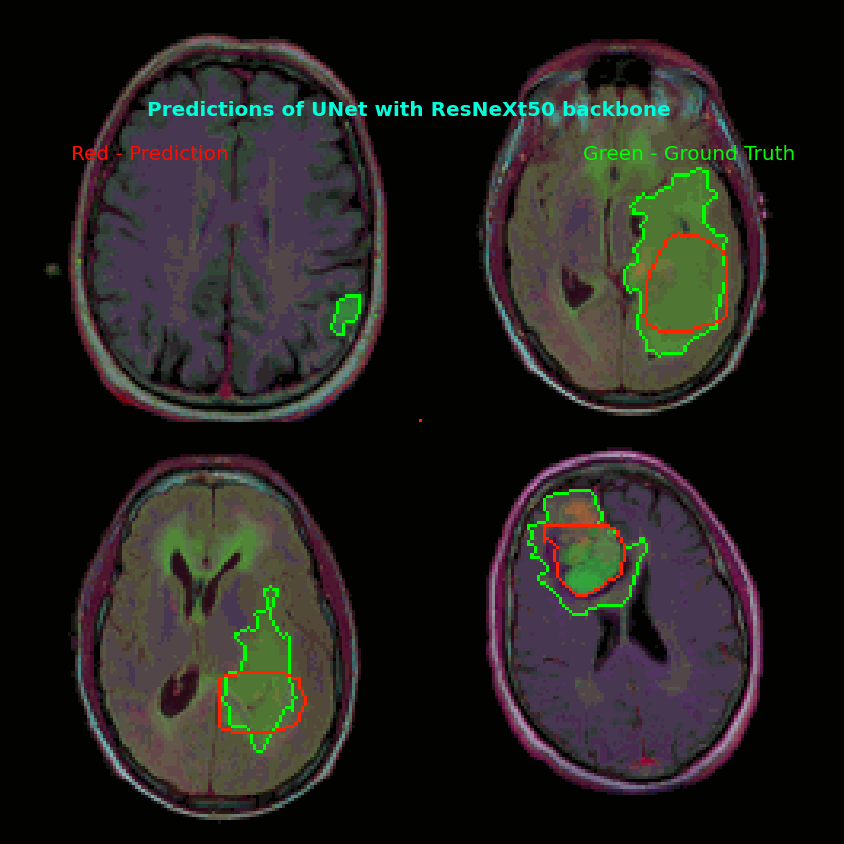

In [42]:
with open(fn3,'rb') as f:
    display(Image_display(data=f.read(), format='png'))
# with open(fn1,'rb') as f:
#     display(Image_display(data=f.read(), format='png'))

In [46]:
torch.save(rx50.state_dict(), '/content/drive/MyDrive/image_processing_project/rx50_model_saved')